In [2]:
import pandas as pd
import numpy as np
import zipfile
import os
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk.corpus import stopwords

In [4]:
# Ensure stopwords are available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Define ZIP file path
zip_path = "C:/Users/prath/Downloads/archive.zip"

In [8]:
# Extract and load CSV from ZIP
with zipfile.ZipFile(zip_path, 'r') as archive:
    archive.extractall("extracted_data")
    csv_filename = archive.namelist()[0]
    csv_path = os.path.join("extracted_data", csv_filename)
data = pd.read_csv(csv_path)

In [9]:
# Check dataset
print("Dataset loaded successfully!\n", data.head())

Dataset loaded successfully!
    Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


In [10]:
# Ensure "tweet" column exists
if "tweet" in data.columns:
    print("Column 'tweet' found. Proceeding with cleaning...")
else:
    raise ValueError("Column 'tweet' not found in the dataset!")

Column 'tweet' found. Proceeding with cleaning...


In [11]:
# Define stopwords and stemmer
stopword = set(stopwords.words('english'))
stemmer = nltk.SnowballStemmer('english')

In [12]:
# Function to clean text
def clean_data(text):
    text = str(text).lower()
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"<.*?>+", "", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub(r"\n", "", text)
    text = re.sub(r"\w*\d\w*", "", text)

    text = [word for word in text.split(" ") if word not in stopword]
    text = " ".join(text)

    text = [stemmer.stem(word) for word in text.split(" ")]
    text = " ".join(text)

    return text

In [13]:
# Apply cleaning function
data["tweet"] = data["tweet"].apply(clean_data)

In [14]:
# Check for missing values
print("Missing values per column:\n", data.isnull().sum())


Missing values per column:
 Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


In [15]:
# Mapping class labels
if "class" in data.columns:
    data["labels"] = data["class"].map({
        0: "Hate Speech",
        1: "Offensive Speech",
        2: "No Hate and Offensive Speech"
    })
else:
    raise ValueError("Column 'class' not found in dataset!")

In [16]:
# Selecting relevant columns
data = data[["tweet", "labels"]]

In [17]:
# Convert text and labels into numpy arrays
X = np.array(data["tweet"])
y = np.array(data["labels"])

In [18]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
# Convert text data to numerical format using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [21]:
# Train Decision Tree Model
dt = DecisionTreeClassifier()
dt.fit(X_train_vect, y_train)

DecisionTreeClassifier()

In [22]:

# Predict on test data
y_pred = dt.predict(X_test_vect)

In [23]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 153   39  273]
 [  36 1116  227]
 [ 234  220 5881]]


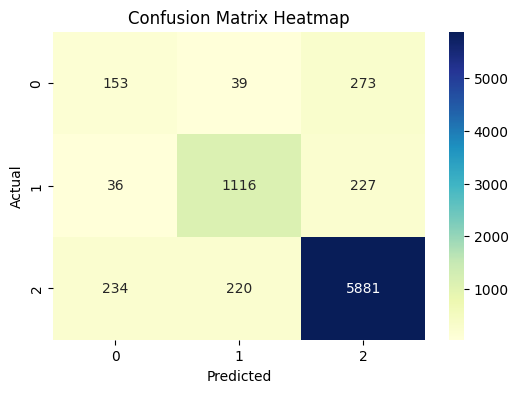

In [24]:
# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

C:\Users\prath\AppData\Local\Temp\ipykernel_29984\845303799.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="labels", palette="coolwarm", order=data["labels"].value_counts().index)


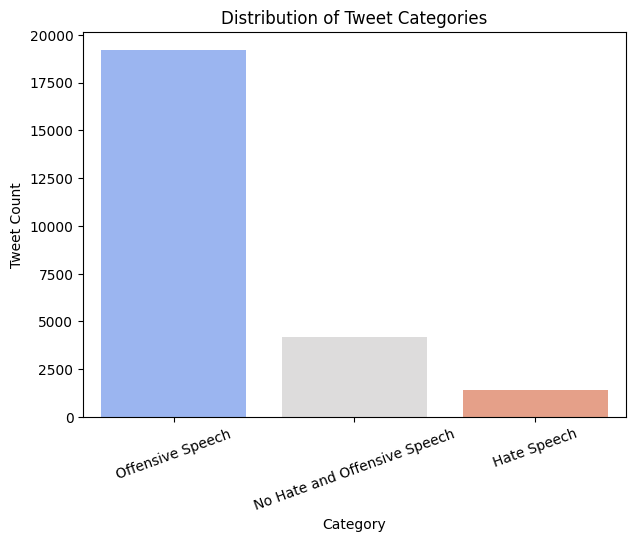

In [25]:
# **Visualization 1: Label Distribution**
plt.figure(figsize=(7,5))
sns.countplot(data=data, x="labels", palette="coolwarm", order=data["labels"].value_counts().index)
plt.title("Distribution of Tweet Categories")
plt.xlabel("Category")
plt.ylabel("Tweet Count")
plt.xticks(rotation=20)
plt.show()

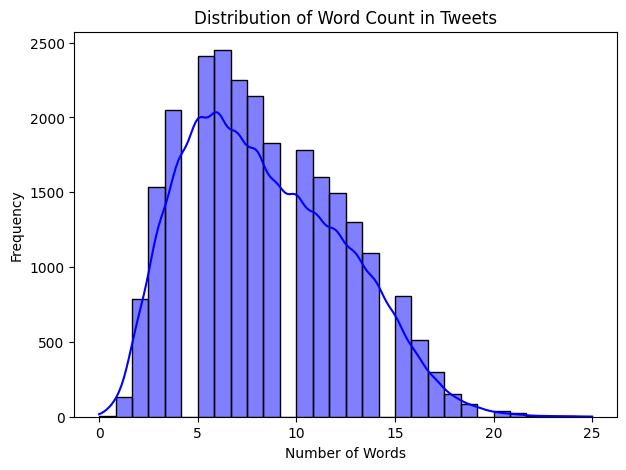

In [26]:
# Word Count Histogram
data["word_count"] = data["tweet"].apply(lambda x: len(x.split()))
plt.figure(figsize=(7,5))
sns.histplot(data["word_count"], bins=30, kde=True, color='blue')
plt.title("Distribution of Word Count in Tweets")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

C:\Users\prath\AppData\Local\Temp\ipykernel_29984\2930890008.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_unique, y=counts, palette="mako")


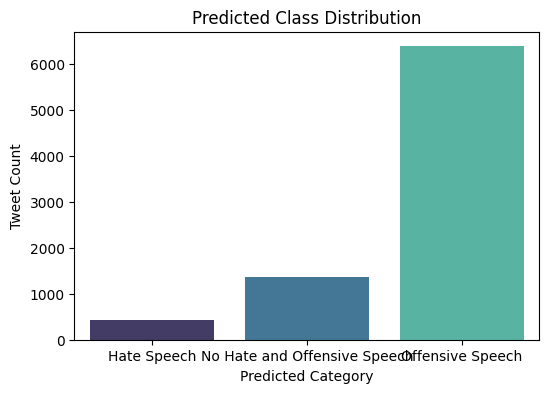

In [27]:
# Classification Results
labels_unique, counts = np.unique(y_pred, return_counts=True)
plt.figure(figsize=(6,4))
sns.barplot(x=labels_unique, y=counts, palette="mako")
plt.title("Predicted Class Distribution")
plt.xlabel("Predicted Category")
plt.ylabel("Tweet Count")
plt.show()

In [29]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.87
